# Artificial Neural Networks and Deep Learning











---











# Homework 1

## ⚙️ Import Libraries

In [2]:
import numpy as np
import tensorflow as tf
import seaborn as sns
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
)
import matplotlib.gridspec as gridspec

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

E0000 00:00:1731332276.306983      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:479
D1111 13:37:56.315290538      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D1111 13:37:56.315305128      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D1111 13:37:56.315308496      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D1111 13:37:56.315311005      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D1111 13:37:56.315313522      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defau

## ⏳ Load the Data

In [3]:
# Load Data
# data = np.load('clean_data.npz')
data = np.load("/kaggle/input/clean-data/aug_data.npz")
x = data["images"]
y = data["labels"]
np.unique(y, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32),
 array([2330, 2330, 2330, 2330, 2330, 2330, 2330, 2330]))

In [4]:
# Labels dictionary
labels_dict = {
    0: "Basophil",
    1: "Eosinophil",
    2: "Erythroblast",
    3: "Immature granulocytes",
    4: "Lymphocyte",
    5: "Monocyte",
    6: "Neutrophil",
    7: "Platelet",
}

In [5]:
class_count = {}

for i in labels_dict:
    class_count[i] = np.unique(y, return_counts=True)[1][i]

class_count

{0: 2330, 1: 2330, 2: 2330, 3: 2330, 4: 2330, 5: 2330, 6: 2330, 7: 2330}

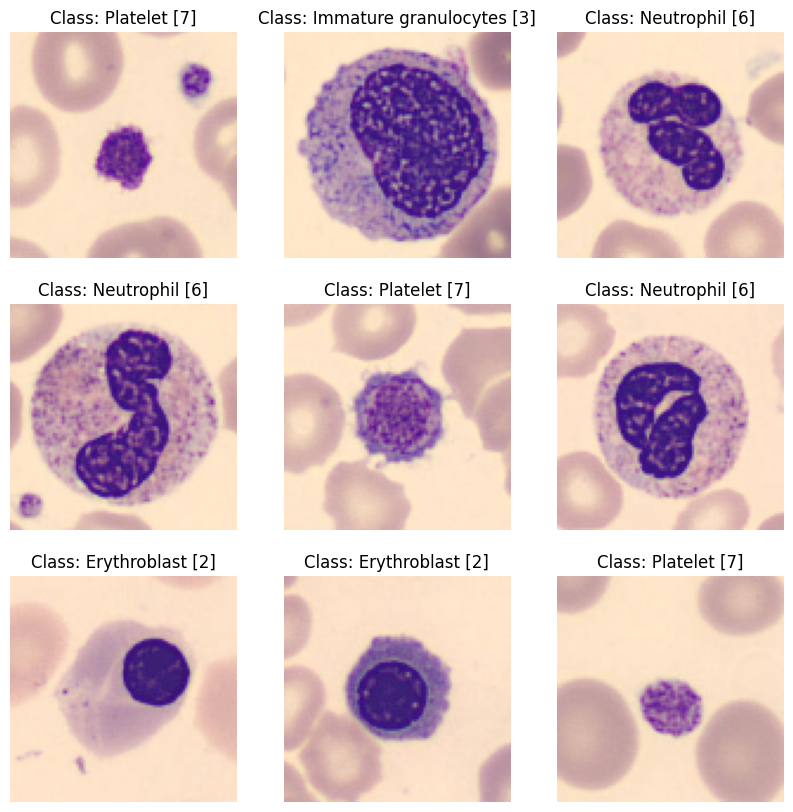

In [6]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.reshape((-1,))

for i in range(9):

    axs[i].imshow(x[i])

    axs[i].set_title(f"Class: {labels_dict[y[i][0]]} {y[i]}")

    axs[i].axis("off")

## 🔄 Process Data

In [7]:
# Normalize data to the range [0, 1]
x = (x / 255).astype("float32")

# Convert labels to categorical format using one-hot encoding
y = tfk.utils.to_categorical(y)

In [8]:
test_val_size = 0.05  # parameter to tune

# Split data into train_val and test sets

X_train_val, X_test, y_train_val, y_test = train_test_split(
    x, y, random_state=seed, test_size=test_val_size, stratify=np.argmax(y, axis=1)
)

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    random_state=seed,
    test_size=len(X_test),
    stratify=np.argmax(y_train_val, axis=1),
)

# Print shapes of the datasets

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (16776, 96, 96, 3), y_train shape: (16776, 8)
X_val shape: (932, 96, 96, 3), y_val shape: (932, 8)
X_test shape: (932, 96, 96, 3), y_test shape: (932, 8)


## 🧮 Define Network Parameters

In [9]:
# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (96, 96, 3)
Output Shape: 8


In [10]:
# Number of training epochs
epochs = 100  # parameter to tune

# Batch size for training
batch_size = 32  # parameter to tune

# Learning rate: step size for updating the model's weights
learning_rate = 0.001  # parameter to tune

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Learning Rate:", learning_rate)

Epochs: 100
Batch Size: 32
Learning Rate: 0.001


## 🛠️ Build the Model

In [11]:
def build_model(
    input_shape=input_shape,
    output_shape=output_shape,
    learning_rate=learning_rate,
    seed=seed,
):

    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    inputs = tfkl.Input(shape=input_shape, name="Input")
    x = tfkl.Conv2D(filters=32, kernel_size=3, padding="same", name="conv1")(inputs)
    x = tfkl.Activation("relu", name="act1")(x)
    x = tfkl.MaxPooling2D(pool_size=2, name="mp1")(x)
    x = tfkl.Conv2D(filters=64, kernel_size=3, padding="same", name="conv2")(x)
    x = tfkl.Activation("relu", name="act2")(x)
    x = tfkl.MaxPooling2D(pool_size=2, name="mp2")(x)
    x = tfkl.Flatten(name="flatten")(x)
    x = tfkl.Dense(units=output_shape, name="dense")(x)
    outputs = tfkl.Activation("softmax", name="softmax")(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=inputs, outputs=outputs, name="CNN")

    # Compile the model
    loss = tfk.losses.CategoricalCrossentropy()
    optimizer = tfk.optimizers.Adam(learning_rate)
    metrics = ["accuracy"]
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    # Return the model
    return model

In [12]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

# instantiate a distribution strategy
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

# instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():
    model = build_model()

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
tfk.utils.plot_model(
    model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70
)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1731332322.572846      13 service.cc:145] XLA service 0x55dfebdac460 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731332322.572901      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1731332322.572905      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1731332322.572908      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1731332322.572912      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1731332322.572915      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1731332322.572917      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1731332322.572920      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1731332322.572922      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

I0000 00:00:1731332326.816448      13 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ Input (InputLayer)          │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv1 (Conv2D)              │ (None, 96, 96, 32)    │        896 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ act1 (Activation)           │ (None, 96, 96, 32)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mp1 (MaxPooling2D)          │ (None, 48, 48, 32)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2 (Conv2D)              │ (None, 48, 48, 64)    │     18,496 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ act2 (Activation)           │ (None, 48, 48, 64)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mp2 (MaxPooling2D)          │ (None, 24, 24, 64)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten (Flatten)           │ (None, 36864)         │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 8)             │    294,920 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ softmax (Activation)        │ (None, 8)             │          0 │   -   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 314,312 (1.20 MB)

 Trainable params: 314,312 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


## 🛠️ Train and Save the Model

In [13]:
# Define the patience value for early stopping
patience = 30

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor="val_accuracy", mode="max", patience=patience, restore_best_weights=True
)

# Store the callback in a list
callbacks = [early_stopping]

In [14]:
# Train the model with early stopping callback
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
).history

Epoch 1/100


2024-11-11 13:38:55.431326: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1731332335.658304     824 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(ce57a0675f83baa9:0:0), session_name()


 15/525 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.2133 - loss: 2.0735

I0000 00:00:1731332337.839494     824 tpu_compile_op_common.cc:245] Compilation of ce57a0675f83baa9:0:0 with session name  took 2.181144896s and succeeded
I0000 00:00:1731332337.843808     824 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(ce57a0675f83baa9:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_8814363056076678256", property.function_library_fingerprint = 4598307467196015417, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,96,96,3,;4,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1731332337.843841     824 tpu_compilation_cache_interface.cc:541] After adding entry for key ce57

524/525 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2083 - loss: 1.9380

I0000 00:00:1731332343.093885     802 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(a78533a89e5e8cac:0:0), session_name()


525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2086 - loss: 1.9376

I0000 00:00:1731332344.842922     802 tpu_compile_op_common.cc:245] Compilation of a78533a89e5e8cac:0:0 with session name  took 1.748996483s and succeeded
I0000 00:00:1731332344.846136     802 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(a78533a89e5e8cac:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_8814363056076678256", property.function_library_fingerprint = 4598307467196015417, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,96,96,3,;2,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1731332344.846166     802 tpu_compilation_cache_interface.cc:541] After adding entry for key a785

525/525 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.2088 - loss: 1.9371 - val_accuracy: 0.5043 - val_loss: 1.2418
Epoch 2/100


I0000 00:00:1731332349.759592     812 tpu_compile_op_common.cc:245] Compilation of b96ca4d92d7a93d5:0:0 with session name  took 1.349243778s and succeeded
I0000 00:00:1731332349.761191     812 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(b96ca4d92d7a93d5:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_15605923571912559600", property.function_library_fingerprint = 3881966807585259448, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,96,96,3,;2,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1731332349.761233     812 tpu_compilation_cache_interface.cc:541] After adding entry for key b96

525/525 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5099 - loss: 1.3017 - val_accuracy: 0.5812 - val_loss: 1.0842
Epoch 3/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5558 - loss: 1.1885 - val_accuracy: 0.6581 - val_loss: 0.9782
Epoch 4/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6299 - loss: 1.0891 - val_accuracy: 0.7265 - val_loss: 0.8688
Epoch 5/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.6509 - loss: 1.0040 - val_accuracy: 0.7436 - val_loss: 0.7948
Epoch 6/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6737 - loss: 0.9437 - val_accuracy: 0.7521 - val_loss: 0.7492
Epoch 7/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6894 - loss: 0.9006 - val_accuracy: 0.7607 - val_loss: 0.7218
Epoch 8/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7036 - loss: 0.8674 - val_accuracy: 0.7692 - val_loss: 0.7066
Epoch 9/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7214 - loss: 0.8403 - val_accuracy

In [15]:
# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history["val_accuracy"]) * 100, 2)
print(f"Final validation accuracy: {final_val_accuracy}%")

# Save the trained model to a file with the accuracy included in the filename
with tpu_strategy.scope():
    model_filename = "cell.keras"
    model.save(model_filename)
    
    # Delete the model to free up resources
    del model

Final validation accuracy: 76.92%


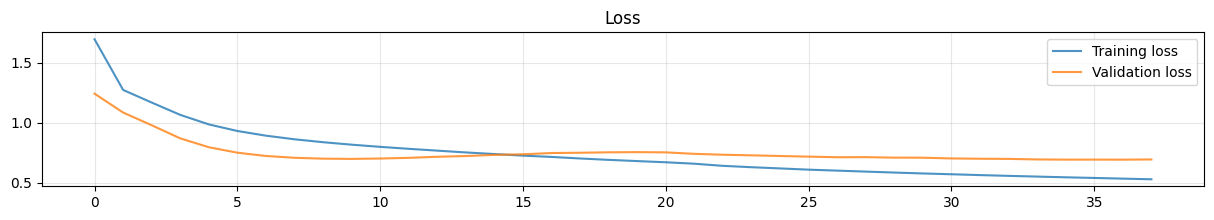

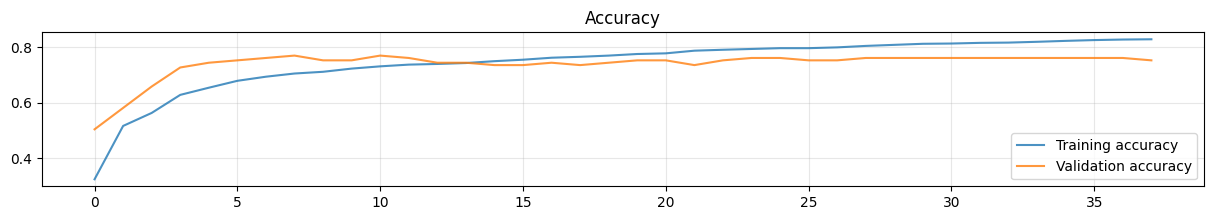

In [16]:
# Plot training and validation loss

plt.figure(figsize=(15, 2))
plt.plot(history["loss"], label="Training loss", alpha=0.8)
plt.plot(history["val_loss"], label="Validation loss", alpha=0.8)
plt.title("Loss")
plt.legend()
plt.grid(alpha=0.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history["accuracy"], label="Training accuracy", alpha=0.8)
plt.plot(history["val_accuracy"], label="Validation accuracy", alpha=0.8)
plt.title("Accuracy")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 🕹️ Use the Model - Make Inference

In [17]:
# Load the saved model

# model = tfk.models.load_model('cell.keras')

model = tfk.models.load_model('/kaggle/working/cell.keras')

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ Input (InputLayer)          │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv1 (Conv2D)              │ (None, 96, 96, 32)    │        896 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ act1 (Activation)           │ (None, 96, 96, 32)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mp1 (MaxPooling2D)          │ (None, 48, 48, 32)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2 (Conv2D)              │ (None, 48, 48, 64)    │     18,496 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ act2 (Activation)           │ (None, 48, 48, 64)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mp2 (MaxPooling2D)          │ (None, 24, 24, 64)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten (Flatten)           │ (None, 36864)         │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 8)             │    294,920 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ softmax (Activation)        │ (None, 8)             │          0 │   -   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 942,938 (3.60 MB)

 Trainable params: 314,312 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 628,626 (2.40 MB)

932
Accuracy score over the test set: 0.7039
Precision score over the test set: 0.7094
Recall score over the test set: 0.7039
F1 score over the test set: 0.6944


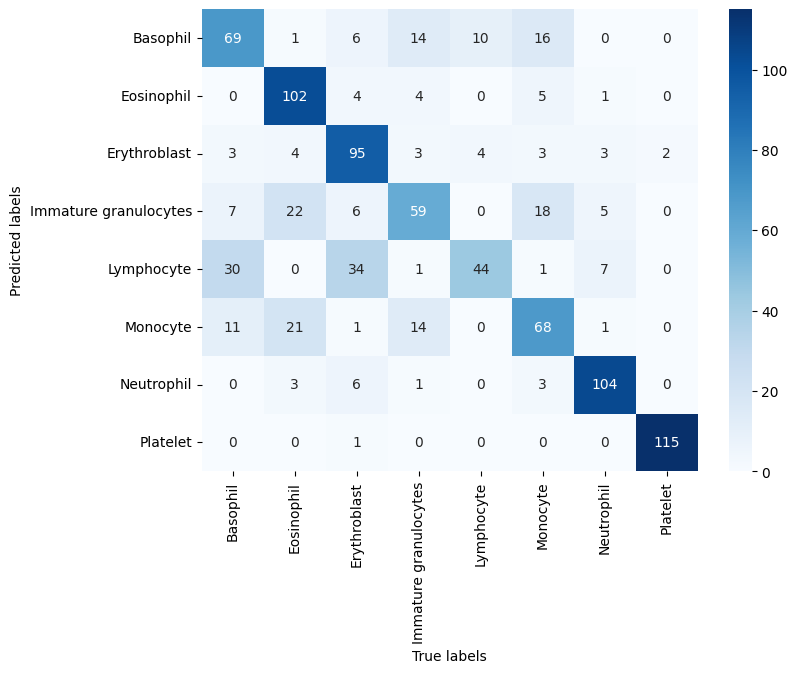

In [18]:
# Predict class probabilities and get predicted classes

test_predictions = model.predict(X_test, verbose=0)
print(len(test_predictions))
test_predictions = np.argmax(test_predictions, axis=-1)

# Extract ground truth classes
test_gt = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
test_accuracy = accuracy_score(test_gt, test_predictions)
print(f"Accuracy score over the test set: {round(test_accuracy, 4)}")

# Calculate and display test set precision
test_precision = precision_score(test_gt, test_predictions, average="weighted")
print(f"Precision score over the test set: {round(test_precision, 4)}")

# Calculate and display test set recall
test_recall = recall_score(test_gt, test_predictions, average="weighted")
print(f"Recall score over the test set: {round(test_recall, 4)}")

# Calculate and display test set F1 score
test_f1 = f1_score(test_gt, test_predictions, average="weighted")
print(f"F1 score over the test set: {round(test_f1, 4)}")

# Compute the confusion matrix
cm = confusion_matrix(test_gt, test_predictions)

# Create labels combining confusion matrix values
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix with class labels
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=labels,
    fmt="",
    xticklabels=list(labels_dict.values()),
    yticklabels=list(labels_dict.values()),
    cmap="Blues",
)

plt.xlabel("True labels")
plt.ylabel("Predicted labels")
plt.show()

Text(0.5, 1.0, 'Real label: 1')

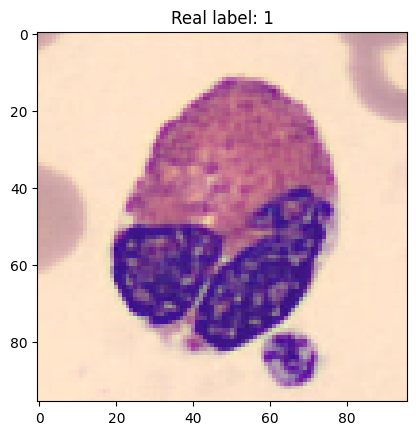

In [19]:
# Let's analyze one specific prediction
test1 = X_test[0]

# show image with real label
plt.imshow(test1*255)
plt.title(f"Real label: {np.argmax(y_test[0])}")

In [20]:
# Reshape the image to match the input shape of the model
test1 = test1.reshape(1, *test1.shape)

print(X_test.shape)
print(test1.shape)

(932, 96, 96, 3)
(1, 96, 96, 3)


In [21]:
test1_pred = model.predict(test1, verbose=0)
print(len(test1_pred))
test1_pred = np.argmax(test_predictions, axis=-1)
print(f"Predicted class: {test1_pred}")
print(f"Real class: {np.argmax(y_test[0])}")

1
Predicted class: 5
Real class: 1


In [22]:
len(test_predictions)

932

## 📊 Prepare Your Submission


To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:


```python

# file: model.py

class Model:

    def __init__(self):


        """Initialize the internal state of the model."""


    def predict(self, X):


        """Return a numpy array with the labels corresponding to the input X."""

```

The next cell shows an example implementation of the `model.py` file, which includes loading model weights from the `weights.keras` file and conducting predictions on provided input data. The `.zip` file is created and downloaded in the last notebook cell.


❗ Feel free to modify the method implementations to better fit your specific requirements, but please ensure that the class name and method interfaces remain unchanged.

In [23]:
%%writefile model.py

import numpy as np
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:

    def __init__(self):

        """

        Initialize the internal state of the model. Note that the __init__

        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained

        model.

        """

        self.neural_network = tfk.models.load_model('cell.keras')


    def predict(self, X):

        """

        Predict the labels corresponding to the input X. Note that X is a numpy

        array of shape (n_samples, 96, 96, 3) and the output should be a numpy

        array of shape (n_samples,). Therefore, outputs must no be one-hot

        encoded.

        The following is an example of a prediction from the pre-trained model

        loaded in the __init__ method.

        """

        preds = self.neural_network.predict(X, verbose=0)

        # Get the predicted classes, not the one-hot encoded values
        preds = np.argmax(preds, axis=-1)

        return preds

Writing model.py


In [24]:
from datetime import datetime

filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py cell.keras

# from google.colab import files
# files.download(filename)

/usr/bin/sh: 1: zip: not found
